## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
    
data_dir = 'notebooks/videos/MRI515_T1'
video_dir = os.path.join(data_dir, 'img_in_jpg_L4L5_renamed')
label_jpg_dir = 'label_in_png_L4L5_renamed'


# prompt_idx = [0]
prompt_idx = [0,1,2]
prompt_idx = [0,1]
prompt_idx = [0]



### Loading the SAM 2 video predictor

In [2]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

len(frame_names) 415
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg'] ->->->->-> ['00410.jpg', '00411.jpg', '00412.jpg', '00413.jpg', '00414.jpg']


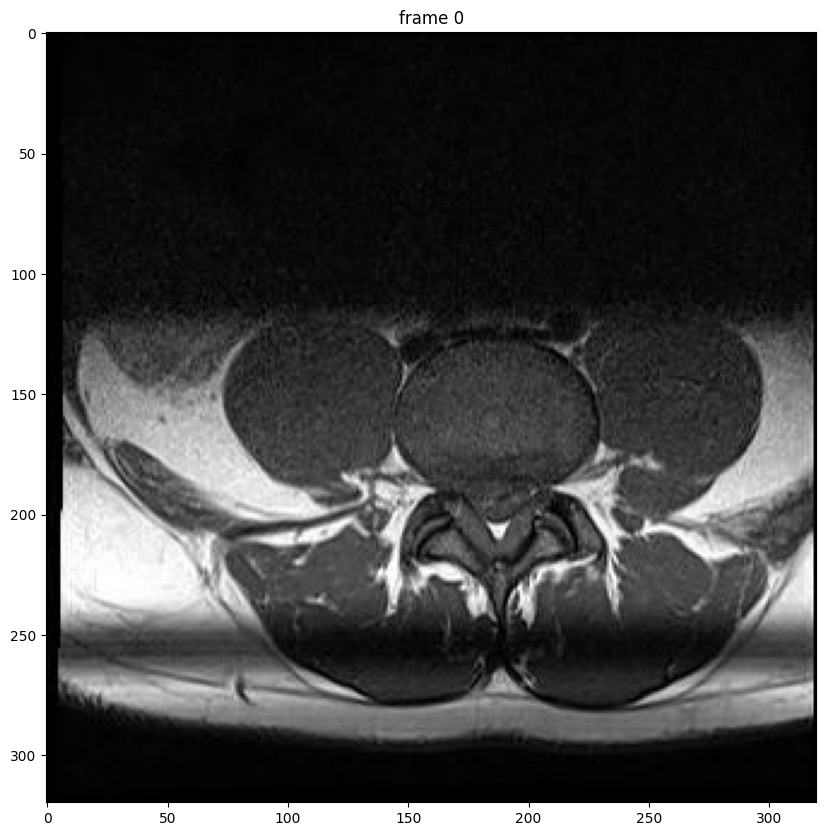

In [4]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(10, 10))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])), cmap='grey')
print('len(frame_names)',len(frame_names))
print(frame_names[:5], '->'*5,frame_names[-5:])


In [5]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|███████████████████| 415/415 [00:05<00:00, 70.32it/s]


In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 定义类别
class_ranges = {    1: (30, 70),     2: (80, 120),     3: (130, 170),      4: (180, 220) }

# 处理每个 prompt index
for idx in prompt_idx:
    img_path = os.path.join(video_dir, frame_names[idx])
    seg_path = os.path.join(data_dir, label_jpg_dir, str(idx).zfill(5) + '.png')

    print(idx, f"Image path: {img_path}")
    print(idx, f"Segmentation path: {seg_path}")

    try:
        # 读取图像并转换为灰度图
        seg_image = Image.open(seg_path).convert("L")
        img_image = Image.open(img_path).convert("L")  # 读取原始图像作为背景
    except Exception as e:
        print(f"Error reading image {idx}: {e}")
        continue

    # 转换为 NumPy 数组
    seg_array = np.array(seg_image)
    img_array = np.array(img_image)

    # 创建类别掩码
    class_masks = {}
    for class_id, (low, high) in class_ranges.items():
        mask = (seg_array >= low) & (seg_array <= high)
        class_mask = np.zeros_like(seg_array, dtype=np.uint8)
        class_mask[mask] = 1

        # 调整大小匹配原始图像
        class_mask = np.array(Image.fromarray(class_mask).resize(img_array.shape[::-1], Image.NEAREST))
        class_masks[class_id] = class_mask

    ann_frame_idx = idx  # 交互的帧索引

    # 逐个添加掩码
    for ann_obj_id, class_mask in class_masks.items():
        print(f"Processed frame {idx} with {ann_obj_id} objid.")

        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            mask=class_mask
        )

    print(f"Processed frame {idx} with {len(class_masks)} classes.")


0 Image path: notebooks/videos/MRI515_T1/img_in_jpg_L4L5_renamed/00000.jpg
0 Segmentation path: notebooks/videos/MRI515_T1/label_in_png_L4L5_renamed/00000.png
Processed frame 0 with 1 objid.
Processed frame 0 with 2 objid.
Processed frame 0 with 3 objid.
Processed frame 0 with 4 objid.
Processed frame 0 with 4 classes.


In [7]:
iou_score_return = True
max_frame_num_to_track = len(frame_names)

video_segments, video_segments_nolap, iou_score = {}, {}, {}

for out in predictor.propagate_in_video(inference_state, 
                                        iou_score_return=iou_score_return, 
                                        max_frame_num_to_track=max_frame_num_to_track):
    out_frame_idx, out_obj_ids, out_mask_logits = out[:3]
    ious = out[3] if iou_score_return else None
    
    video_segments[out_frame_idx] = {
        obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, obj_id in enumerate(out_obj_ids)
    }
    
    if iou_score_return:
        iou_score[out_frame_idx] = {obj_id: ious[i] for i, obj_id in enumerate(out_obj_ids)}
        
        
    # Resolve overlaps
      
    frame_masks = {
        obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() * out_mask_logits[i].cpu().numpy()
        for i, obj_id in enumerate(out_obj_ids)
    }  

    
    stacked_masks = np.stack([frame_masks[obj_id] > 0 for obj_id in frame_masks], axis=0)
    stacked_logits = np.stack([frame_masks[obj_id] for obj_id in frame_masks], axis=0)
    max_logits_indices = np.argmax(stacked_logits, axis=0)
    
    video_segments_nolap[out_frame_idx] = {
        obj_id: (max_logits_indices == i).astype(np.uint8) & stacked_masks[i]
        for i, obj_id in enumerate(frame_masks)
    }


propagate in video: 100%|█████████████████████| 415/415 [08:40<00:00,  1.26s/it]


In [8]:
import os
import torch
import pandas as pd

vis_frame_stride = 1

# 定义 CSV 文件名
csv_write_path = os.path.join(data_dir, "iou_results.csv")

# 计算 IOU 结果并存储
results = []
for f_idx in range(0, max_frame_num_to_track, vis_frame_stride):
    for o_id, iou in iou_score[f_idx].items():
        max_iou = torch.max(iou).item()
        results.append({"frame_idx": f_idx, "obj_id": o_id, "iou": max_iou})

# 保存结果并转换格式
results_df = pd.DataFrame(results)

# 转换为宽格式并打印
wide_df = results_df.pivot(index="frame_idx", columns="obj_id", values="iou")
wide_df.columns = [f"iou_id{col}" for col in wide_df.columns]
wide_df["iou_sum"] = wide_df.sum(axis=1)

wide_df.to_csv(csv_write_path, index=True)
print(f"数据已成功写入 {csv_write_path}")

print(wide_df.reset_index())


数据已成功写入 notebooks/videos/MRI515_T1/iou_results.csv
     frame_idx   iou_id1   iou_id2   iou_id3   iou_id4   iou_sum
0            0  1.000000  1.000000  1.000000  1.000000  4.000000
1            1  0.740416  0.821832  0.857456  0.781184  3.200888
2            2  0.779501  0.616919  0.738526  0.526382  2.661328
3            3  0.845483  0.686267  0.684419  0.688742  2.904910
4            4  0.884100  0.726398  0.783406  0.824581  3.218484
..         ...       ...       ...       ...       ...       ...
410        410  0.880832  0.727917  0.856277  0.750886  3.215912
411        411  0.534546  0.725681  0.752735  0.465433  2.478396
412        412  0.714632  0.258829  0.491415  0.567274  2.032150
413        413  0.731062  0.585214  0.641374  0.596027  2.553677
414        414  0.693575  0.878851  0.829344  0.732120  3.133889

[415 rows x 6 columns]


In [9]:
# video_segments_todo = video_segments_nolap
# # video_segments_todo = video_segments



# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), cmap ='grey')
#     for out_obj_id, out_mask in video_segments_todo[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, cmap='gray')

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

# 需要处理的两个数据集
video_segments_dict = {
    "yeslap": video_segments,
    "nolap": video_segments_nolap
}

# 确保目录存在
for key in video_segments_dict.keys():
    os.makedirs(os.path.join(data_dir, f"SAM2_seg_mask_{key}"), exist_ok=True)
    os.makedirs(os.path.join(data_dir, f"SAM2_seg_plot_{key}"), exist_ok=True)

# 处理单个帧的函数
def process_frame(args):
    key, idx, video_segments_todo = args
    seg_dir = os.path.join(data_dir, f"SAM2_seg_mask_{key}")
    vis_dir = os.path.join(data_dir, f"SAM2_seg_plot_{key}")

    frame_path = os.path.join(video_dir, frame_names[idx])
    frame_image = Image.open(frame_path)
    combined_mask = None

    for obj_id, mask in video_segments_todo[idx].items():
        mask = np.squeeze(mask) if mask.ndim > 2 else mask
        scaled_mask = mask * (obj_id * 50)  # 使对象具有不同的灰度值

        # 保存单个对象 mask
        Image.fromarray(scaled_mask.astype("uint8")).save(
            os.path.join(seg_dir, f"frame_{idx}_obj_{obj_id}.png"), "PNG"
        )

        # 生成组合 mask
        combined_mask = np.maximum(combined_mask, scaled_mask) if combined_mask is not None else scaled_mask

    # 保存组合 mask
    if combined_mask is not None:
        Image.fromarray(combined_mask.astype("uint8")).save(
            os.path.join(seg_dir, f"frame_{idx}_combined.png"), "PNG"
        )

    # 画图可视化
    plt.figure(figsize=(6, 4))
    plt.title(f"Frame {idx} ({key})")
    plt.imshow(frame_image, cmap='gray')
    for obj_id, mask in video_segments_todo[idx].items():
        show_mask(np.squeeze(mask) if mask.ndim > 2 else mask, plt.gca(), obj_id=obj_id)

    plt.savefig(os.path.join(vis_dir, f"frame_{idx}_visualization.png"), format="png", dpi=300)
    plt.close()

    print(f"Processed frame {idx} for {key}")

# 多进程加速
if __name__ == '__main__':
    num_workers = min(8, cpu_count())  # 8 个 CPU 核心

    with Pool(num_workers) as pool:
        tasks = []
        for key, video_segments_todo in video_segments_dict.items():
            for idx in range(0, len(frame_names), vis_frame_stride):
                tasks.append((key, idx, video_segments_todo))

        pool.map(process_frame, tasks)  # 并行处理


Processed frame 0 for yeslap
Processed frame 26 for yeslap
Processed frame 52 for yeslap
Processed frame 1 for yeslap
Processed frame 78 for yeslap
Processed frame 27 for yeslap
Processed frame 104 for yeslap
Processed frame 2 for yeslap
Processed frame 53 for yeslap
Processed frame 130 for yeslap
Processed frame 28 for yeslap
Processed frame 79 for yeslap
Processed frame 156 for yeslap
Processed frame 105 for yeslap
Processed frame 80 for yeslap
Processed frame 3 for yeslap
Processed frame 131 for yeslap
Processed frame 54 for yeslap
Processed frame 157 for yeslap
Processed frame 29 for yeslap
Processed frame 182 for yeslap
Processed frame 81 for yeslap
Processed frame 106 for yeslap
Processed frame 132 for yeslap
Processed frame 4 for yeslap
Processed frame 55 for yeslap
Processed frame 158 for yeslap
Processed frame 30 for yeslap
Processed frame 183 for yeslap
Processed frame 107 for yeslap
Processed frame 133 for yeslap
Processed frame 5 for yeslap
Processed frame 82 for yeslap
Pro

Processed frame 395 for yeslap
Processed frame 370 for yeslap
Processed frame 242 for yeslap
Processed frame 268 for yeslap
Processed frame 344 for yeslap
Processed frame 319 for yeslap
Processed frame 219 for yeslap
Processed frame 396 for yeslap
Processed frame 294 for yeslap
Processed frame 243 for yeslap
Processed frame 371 for yeslap
Processed frame 345 for yeslap
Processed frame 269 for yeslap
Processed frame 220 for yeslap
Processed frame 397 for yeslap
Processed frame 320 for yeslap
Processed frame 244 for yeslap
Processed frame 295 for yeslap
Processed frame 346 for yeslap
Processed frame 372 for yeslap
Processed frame 270 for yeslap
Processed frame 221 for yeslap
Processed frame 398 for yeslap
Processed frame 321 for yeslap
Processed frame 245 for yeslap
Processed frame 347 for yeslap
Processed frame 296 for yeslap
Processed frame 373 for yeslap
Processed frame 399 for yeslap
Processed frame 271 for yeslap
Processed frame 222 for yeslap
Processed frame 246 for yeslap
Processe

Processed frame 119 for nolap
Processed frame 196 for nolap
Processed frame 145 for nolap
Processed frame 69 for nolap
Processed frame 19 for nolap
Processed frame 94 for nolap
Processed frame 45 for nolap
Processed frame 170 for nolap
Processed frame 197 for nolap
Processed frame 70 for nolap
Processed frame 120 for nolap
Processed frame 20 for nolap
Processed frame 146 for nolap
Processed frame 46 for nolap
Processed frame 171 for nolap
Processed frame 95 for nolap
Processed frame 71 for nolap
Processed frame 198 for nolap
Processed frame 121 for nolap
Processed frame 21 for nolap
Processed frame 147 for nolap
Processed frame 47 for nolap
Processed frame 172 for nolap
Processed frame 72 for nolapProcessed frame 96 for nolap

Processed frame 199 for nolap
Processed frame 122 for nolap
Processed frame 22 for nolap
Processed frame 148 for nolap
Processed frame 48 for nolap
Processed frame 173 for nolap
Processed frame 97 for nolap
Processed frame 73 for nolap
Processed frame 123 for nol

Processed frame 286 for nolap
Processed frame 386 for nolap
Processed frame 335 for nolap
Processed frame 310 for nolap
Processed frame 361 for nolap
Processed frame 413 for nolap
Processed frame 387 for nolap
Processed frame 336 for nolap
Processed frame 311 for nolap
Processed frame 362 for nolap
Processed frame 414 for nolap
Processed frame 388 for nolap
Processed frame 337 for nolap
Processed frame 363 for nolap
Processed frame 312 for nolap
Processed frame 389 for nolap
Processed frame 338 for nolap
Processed frame 364 for nolap
Processed frame 390 for nolap


In [12]:
import multiprocessing
print("CPU 核心数:", multiprocessing.cpu_count())


CPU 核心数: 12
